In [2]:
import pandas as pd
import keras
import numpy as np
import os
from tqdm import tqdm
from time import time
from sklearn.metrics import roc_curve,roc_auc_score,f1_score,accuracy_score,precision_recall_curve
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,KFold
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image,ImageOps
import glob 
import cv2
import pickle
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 1.x
except Exception:
  pass

import tensorflow as tf

In [3]:
df = pd.read_csv("/Users/swchoi1994/Documents/DL_Projects/Chest-X-ray-DL/data_csv_files/df_AP.csv")
df = df.iloc[:,:-1]

In [4]:
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000032_000.png,Cardiomegaly,0,32,55,F,AP,2500,2048,0.168,0.168
1,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55,F,AP,2500,2048,0.168,0.168
2,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168
3,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55,F,AP,2500,2048,0.168,0.168
4,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
11710,00030770_001.png,Infiltration,1,30770,23,F,AP,3056,2544,0.139,0.139
11711,00030770_002.png,No Finding,2,30770,23,F,AP,3056,2544,0.139,0.139
11712,00030772_000.png,No Finding,0,30772,26,F,AP,3056,2544,0.139,0.139
11713,00030772_001.png,Consolidation,1,30772,26,F,AP,3056,2544,0.139,0.139


In [5]:
df_final = pd.DataFrame(columns=df.columns)
for _,record in df.iloc[:,:].iterrows():
  rec = record.copy(deep=True)
  if '|' in str(record['Finding Labels']):
    labels = str(record['Finding Labels']).split('|')
    for label in labels:
      rec['Finding Labels'] = label
      df_final= df_final.append(rec,ignore_index=True)
  else:
    df_final = df_final.append(record,ignore_index=True)

df_final

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000032_000.png,Cardiomegaly,0,32,55,F,AP,2500,2048,0.168,0.168
1,00000032_001.png,Cardiomegaly,1,32,55,F,AP,2500,2048,0.168,0.168
2,00000032_001.png,Edema,1,32,55,F,AP,2500,2048,0.168,0.168
3,00000032_001.png,Effusion,1,32,55,F,AP,2500,2048,0.168,0.168
4,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
15117,00030770_001.png,Infiltration,1,30770,23,F,AP,3056,2544,0.139,0.139
15118,00030770_002.png,No Finding,2,30770,23,F,AP,3056,2544,0.139,0.139
15119,00030772_000.png,No Finding,0,30772,26,F,AP,3056,2544,0.139,0.139
15120,00030772_001.png,Consolidation,1,30772,26,F,AP,3056,2544,0.139,0.139


In [17]:
my_glob = glob.glob('/Users/swchoi1994/Documents/DL_Projects/Chest-X-ray-DL/NIH/X_Rays/*.png')
print('Number of Observations: ', len(my_glob))

Number of Observations:  112121


In [18]:
my_glob[:100]

['/Users/swchoi1994/Documents/DL_Projects/Chest-X-ray-DL/NIH/X_Rays/00018805_001.png',
 '/Users/swchoi1994/Documents/DL_Projects/Chest-X-ray-DL/NIH/X_Rays/00005868_002.png',
 '/Users/swchoi1994/Documents/DL_Projects/Chest-X-ray-DL/NIH/X_Rays/00009663_000.png',
 '/Users/swchoi1994/Documents/DL_Projects/Chest-X-ray-DL/NIH/X_Rays/00022156_007.png',
 '/Users/swchoi1994/Documents/DL_Projects/Chest-X-ray-DL/NIH/X_Rays/00005395_004.png',
 '/Users/swchoi1994/Documents/DL_Projects/Chest-X-ray-DL/NIH/X_Rays/00006966_004.png',
 '/Users/swchoi1994/Documents/DL_Projects/Chest-X-ray-DL/NIH/X_Rays/00000324_013.png',
 '/Users/swchoi1994/Documents/DL_Projects/Chest-X-ray-DL/NIH/X_Rays/00007442_018.png',
 '/Users/swchoi1994/Documents/DL_Projects/Chest-X-ray-DL/NIH/X_Rays/00003923_012.png',
 '/Users/swchoi1994/Documents/DL_Projects/Chest-X-ray-DL/NIH/X_Rays/00028483_007.png',
 '/Users/swchoi1994/Documents/DL_Projects/Chest-X-ray-DL/NIH/X_Rays/00024175_003.png',
 '/Users/swchoi1994/Documents/DL_Projects/C

In [19]:
df_final.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]'],
      dtype='object')

In [20]:
full_img_paths = {os.path.basename(x): x for x in my_glob}
df_final['full_path'] = df_final['Image Index'].map(full_img_paths.get)

In [21]:
df_final

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],full_path
0,00000032_000.png,Cardiomegaly,0,32,55,F,AP,2500,2048,0.168,0.168,/Users/swchoi1994/Documents/DL_Projects/Chest-...
1,00000032_001.png,Cardiomegaly,1,32,55,F,AP,2500,2048,0.168,0.168,/Users/swchoi1994/Documents/DL_Projects/Chest-...
2,00000032_001.png,Edema,1,32,55,F,AP,2500,2048,0.168,0.168,/Users/swchoi1994/Documents/DL_Projects/Chest-...
3,00000032_001.png,Effusion,1,32,55,F,AP,2500,2048,0.168,0.168,/Users/swchoi1994/Documents/DL_Projects/Chest-...
4,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168,/Users/swchoi1994/Documents/DL_Projects/Chest-...
...,...,...,...,...,...,...,...,...,...,...,...,...
15117,00030770_001.png,Infiltration,1,30770,23,F,AP,3056,2544,0.139,0.139,/Users/swchoi1994/Documents/DL_Projects/Chest-...
15118,00030770_002.png,No Finding,2,30770,23,F,AP,3056,2544,0.139,0.139,/Users/swchoi1994/Documents/DL_Projects/Chest-...
15119,00030772_000.png,No Finding,0,30772,26,F,AP,3056,2544,0.139,0.139,/Users/swchoi1994/Documents/DL_Projects/Chest-...
15120,00030772_001.png,Consolidation,1,30772,26,F,AP,3056,2544,0.139,0.139,/Users/swchoi1994/Documents/DL_Projects/Chest-...


In [8]:
df_final.to_csv("/Users/swchoi1994/Documents/DL_Projects/Chest-X-ray-DL/added_paths_AP.csv",index=False)

In [22]:
df_final.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'full_path'],
      dtype='object')

Frequency Distribution

                    Finding Labels
No Finding                    4485
Infiltration                  3142
Effusion                      1876
Atelectasis                   1510
Consolidation                 1056
Nodule                         645
Edema                          447
Mass                           436
Pneumothorax                   419
Cardiomegaly                   364
Pleural_Thickening             250
Pneumonia                      239
Fibrosis                       138
Emphysema                      114
Hernia                           1


(<AxesSubplot:ylabel='Finding Labels'>,
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
  [Text(0, 0, 'No Finding'),
   Text(1, 0, 'Infiltration'),
   Text(2, 0, 'Effusion'),
   Text(3, 0, 'Atelectasis'),
   Text(4, 0, 'Consolidation'),
   Text(5, 0, 'Nodule'),
   Text(6, 0, 'Edema'),
   Text(7, 0, 'Mass'),
   Text(8, 0, 'Pneumothorax'),
   Text(9, 0, 'Cardiomegaly'),
   Text(10, 0, 'Pleural_Thickening'),
   Text(11, 0, 'Pneumonia'),
   Text(12, 0, 'Fibrosis'),
   Text(13, 0, 'Emphysema'),
   Text(14, 0, 'Hernia')]))

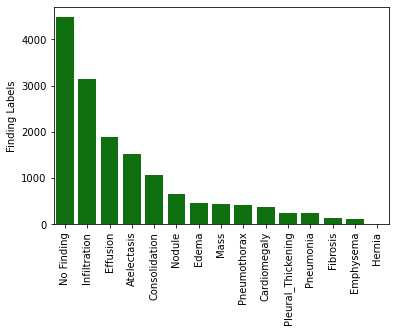

In [27]:
#Frequency distribution for the labels
count_per_unique_label = df_final['Finding Labels'].value_counts()
df_count_per_unique_label = count_per_unique_label.to_frame() # convert series to dataframe for plotting purposes

print(df_count_per_unique_label) # view tabular results
sns.barplot(x = df_count_per_unique_label.index[:], y="Finding Labels", data=df_count_per_unique_label[:], color = "green"), plt.xticks(rotation = 90) # visualize results graphically

In [32]:
df_final.to_csv("/Users/swchoi1994/Documents/DL_Projects/Chest-X-ray-DL/added_paths_AP.csv",index=False)

In [33]:
df = pd.read_csv("/Users/swchoi1994/Documents/DL_Projects/Chest-X-ray-DL/added_paths_AP.csv")
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],full_path
0,00000032_000.png,Cardiomegaly,0,32,55,F,AP,2500,2048,0.168,0.168,/Users/swchoi1994/Documents/DL_Projects/Chest-...
1,00000032_001.png,Cardiomegaly,1,32,55,F,AP,2500,2048,0.168,0.168,/Users/swchoi1994/Documents/DL_Projects/Chest-...
2,00000032_001.png,Edema,1,32,55,F,AP,2500,2048,0.168,0.168,/Users/swchoi1994/Documents/DL_Projects/Chest-...
3,00000032_001.png,Effusion,1,32,55,F,AP,2500,2048,0.168,0.168,/Users/swchoi1994/Documents/DL_Projects/Chest-...
4,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168,/Users/swchoi1994/Documents/DL_Projects/Chest-...


In [34]:
BATCH_SIZE = 32
IMAGE_SIZE = (256,256)
TRAIN_SIZE = 2000
VAL_SIZE = 1000
TEST_SIZE = 400

In [35]:
with open("/Users/swchoi1994/Desktop/csv_files/train_val_list.txt",'r') as f:
  train_links = [line.strip() for line in f.readlines()]
  train_links = np.array(train_links).astype(str)

print(f"Number of train_samples: {len(train_links)}")
train_links[:10]

Number of train_samples: 86524


array(['00000001_000.png', '00000001_001.png', '00000001_002.png',
       '00000002_000.png', '00000004_000.png', '00000005_000.png',
       '00000005_001.png', '00000005_002.png', '00000005_003.png',
       '00000005_004.png'], dtype='<U16')

In [36]:
with open("/Users/swchoi1994/Desktop/csv_files/test_list.txt",'r') as f:
  test_links = [line.strip() for line in f.readlines()]
  test_links = np.array(test_links).astype(str)
print(f"Number of test_samples: {len(test_links)}")
test_links[:10]

Number of test_samples: 25596


array(['00000003_000.png', '00000003_001.png', '00000003_002.png',
       '00000003_003.png', '00000003_004.png', '00000003_005.png',
       '00000003_006.png', '00000003_007.png', '00000013_000.png',
       '00000013_001.png'], dtype='<U16')

In [37]:
df_train = df[df['Image Index'].isin(train_links)]
df_test = df[df['Image Index'].isin(test_links)]

In [38]:
val_split = 0.1 #last 10% of the train data
num_train_overall = df_train.shape[0]
df_train_final = df_train.iloc[:-int(val_split * num_train_overall),:]
df_val = df_train.iloc[-int(val_split * num_train_overall):,:]

classes = ['No Finding','Infiltration',
           'Effusion','Atelectasis','Nodule', 'Mass',
           'Pleural_Thickening','Fibrosis','Pneumothorax',
           'Cardiomegaly','Consolidation','Emphysema',
           'Pneumonia','Hernia','Edema']

mapper = dict(zip(classes, range(0,len(classes))))
mapper

{'No Finding': 0,
 'Infiltration': 1,
 'Effusion': 2,
 'Atelectasis': 3,
 'Nodule': 4,
 'Mass': 5,
 'Pleural_Thickening': 6,
 'Fibrosis': 7,
 'Pneumothorax': 8,
 'Cardiomegaly': 9,
 'Consolidation': 10,
 'Emphysema': 11,
 'Pneumonia': 12,
 'Hernia': 13,
 'Edema': 14}

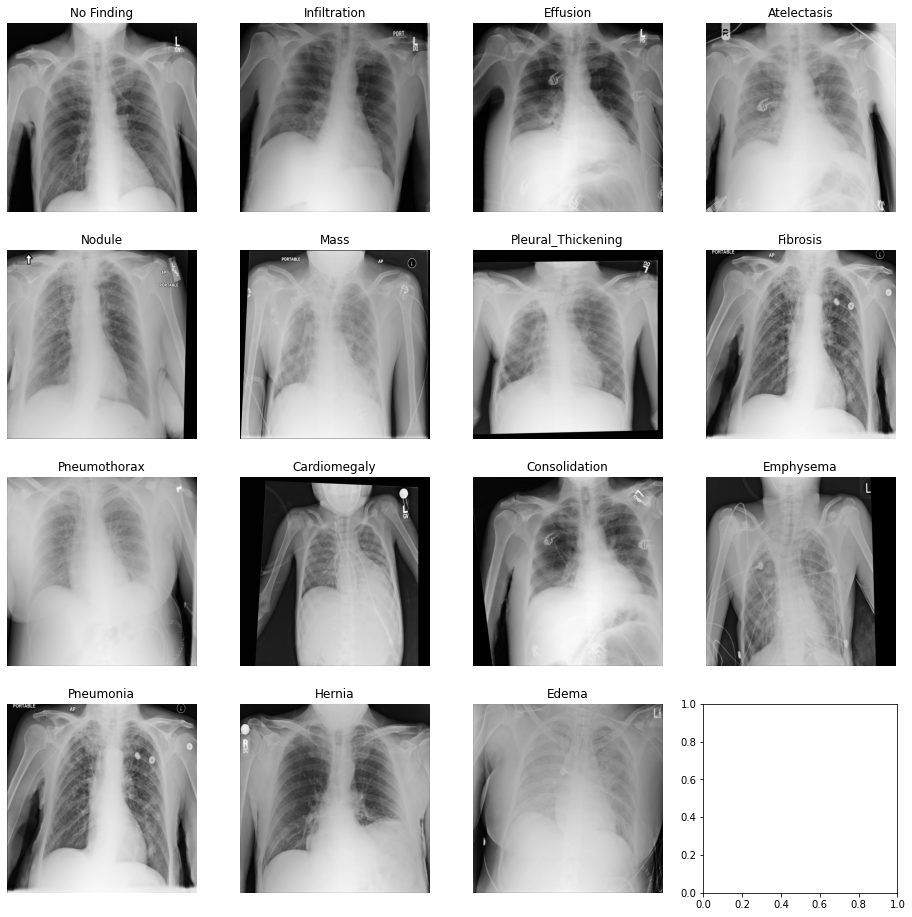

In [39]:
#plot random samples for each class in a subplot basis
fig, axs = plt.subplots(nrows=4,ncols=4,figsize = (16, 16))
for cl in mapper.keys():
  i = mapper[cl] // 4
  j = mapper[cl] % 4
  sample = df_train_final[df_train_final['Finding Labels'] == cl].iloc[0,:]
  path = sample['full_path']
  image = mpimg.imread(path)
  axs[i,j].imshow(image,cmap="gray")
  axs[i,j].set_title(cl)
  axs[i,j].axis('off')

In [40]:
for cl in classes:
  df_train_final[cl] = df_train_final['Finding Labels'].map(lambda result: 1.0 if cl in result else 0)
  df_val[cl] = df_val['Finding Labels'].map(lambda result: 1.0 if cl in result else 0)
  df_test[cl] = df_test['Finding Labels'].map(lambda result: 1.0 if cl in result else 0)


df_train_final['target_vector'] = df_train_final.apply(lambda target: [target[classes].values], 1).map(lambda target: target[0])
df_val['target_vector'] = df_val.apply(lambda target: [target[classes].values], 1).map(lambda target: target[0])
df_test['target_vector'] = df_test.apply(lambda target: [target[classes].values], 1).map(lambda target: target[0])


/Users/swchoi1994/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/swchoi1994/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/swchoi1994/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [41]:
#TRAIN WITH TRAIN SIZE SAMPLES
df_train_final = df_train_final.iloc[:TRAIN_SIZE,:]
df_val = df_val.iloc[:VAL_SIZE,:]

df_test = df_test.iloc[-TEST_SIZE:,:]
df_train_final

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Pleural_Thickening,Fibrosis,Pneumothorax,Cardiomegaly,Consolidation,Emphysema,Pneumonia,Hernia,Edema,target_vector
529,00000179_000.png,No Finding,0,179,63,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
530,00000179_001.png,Infiltration,1,179,63,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
531,00000179_002.png,Atelectasis,2,179,63,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
532,00000179_000.png,No Finding,0,179,63,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
533,00000179_001.png,Infiltration,1,179,63,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3501,00005493_011.png,Nodule,11,5493,71,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3502,00005493_010.png,Nodule,10,5493,71,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3503,00005493_011.png,Nodule,11,5493,71,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3504,00005493_012.png,No Finding,12,5493,71,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [42]:
df_val

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Pleural_Thickening,Fibrosis,Pneumothorax,Cardiomegaly,Consolidation,Emphysema,Pneumonia,Hernia,Edema,target_vector
13595,00029235_006.png,Pneumothorax,6,29235,69,F,AP,3056,2544,0.139,...,0.0,0,1.0,0.0,0.0,0,0.0,0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 1.0, 0...."
13596,00029235_007.png,Pneumothorax,7,29235,69,F,AP,3056,2544,0.139,...,0.0,0,1.0,0.0,0.0,0,0.0,0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 1.0, 0...."
13597,00029245_000.png,Infiltration,0,29245,5,M,AP,2544,3056,0.139,...,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0...."
13598,00029245_001.png,Infiltration,1,29245,5,M,AP,2544,3056,0.139,...,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0...."
13599,00029245_002.png,Infiltration,2,29245,5,M,AP,3056,2544,0.139,...,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15117,00030770_001.png,Infiltration,1,30770,23,F,AP,3056,2544,0.139,...,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0...."
15118,00030770_002.png,No Finding,2,30770,23,F,AP,3056,2544,0.139,...,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0...."
15119,00030772_000.png,No Finding,0,30772,26,F,AP,3056,2544,0.139,...,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0...."
15120,00030772_001.png,Consolidation,1,30772,26,F,AP,3056,2544,0.139,...,0.0,0,0.0,0.0,1.0,0,0.0,0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0...."


In [43]:
df_test

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Pleural_Thickening,Fibrosis,Pneumothorax,Cardiomegaly,Consolidation,Emphysema,Pneumonia,Hernia,Edema,target_vector
14333,00030079_021.png,Effusion,21,30079,16,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
14334,00030079_022.png,Infiltration,22,30079,16,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
14335,00030079_020.png,Infiltration,20,30079,16,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
14336,00030079_021.png,Effusion,21,30079,16,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
14337,00030079_022.png,Pneumonia,22,30079,16,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14969,00030607_001.png,No Finding,1,30607,58,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
14970,00030607_002.png,No Finding,2,30607,58,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
14971,00030607_001.png,No Finding,1,30607,58,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
14972,00030607_002.png,No Finding,2,30607,58,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## **Create the features and the label variables**


In [44]:
def get_vect(df,vect_col):
  y = np.empty((1,15))
  for vec in df[vect_col].values:
    y = np.vstack((y,vec))
  
  y = y[1:]
  print(y.shape)
  return y

In [45]:
def get_image_data(df,path_col,image_size = IMAGE_SIZE):
  num_samples = df.shape[0]
  X = []
  i = 0
  image_paths = df[path_col].values

  for path in tqdm(image_paths):
    image = Image.open(path)
    image = image.convert('L')
    image = np.asarray(image.resize(image_size))
    X.append(image)
  
  print("Shape of the X vector: ",len(X),image_size)
  return X

In [46]:
print("Getting TRAIN DATA")
y_train = get_vect(df_train_final,'target_vector')
%time X_train = get_image_data(df_train_final,"full_path")
print("Getting VAL DATA")
y_val = get_vect(df_val,'target_vector')
%time X_val = get_image_data(df_val,"full_path")

  0%|          | 0/2000 [00:00<?, ?it/s]

Getting TRAIN DATA
(2000, 15)


  1%|          | 6/903 [00:00<00:15, 57.37it/s]

Shape of the X vector:  2000 (256, 256)
CPU times: user 26.7 s, sys: 839 ms, total: 27.5 s
Wall time: 27.8 s
Getting VAL DATA
(903, 15)


100%|██████████| 903/903 [00:12<00:00, 71.20it/s]

Shape of the X vector:  903 (256, 256)
CPU times: user 12.2 s, sys: 380 ms, total: 12.5 s
Wall time: 12.7 s


In [47]:
X_train[:10]

[array([[ 8,  9,  9, ..., 23, 22, 21],
        [ 9, 10, 10, ..., 24, 24, 22],
        [ 9, 10, 10, ..., 22, 22, 20],
        ...,
        [63, 48, 31, ...,  9,  9,  8],
        [63, 43, 28, ...,  7,  9,  9],
        [55, 35, 22, ...,  6,  8,  8]], dtype=uint8),
 array([[  2,   2,   2, ..., 147, 149, 138],
        [  2,   2,   2, ..., 161, 164, 152],
        [  2,   2,   2, ..., 158, 162, 149],
        ...,
        [  3,   6,  26, ...,  69,  72,  68],
        [  3,   8,  30, ...,  71,  73,  67],
        [  3,  10,  30, ...,  59,  66,  59]], dtype=uint8),
 array([[ 19,  21,  22, ..., 191, 194, 181],
        [ 23,  24,  23, ..., 210, 213, 199],
        [ 22,  23,  22, ..., 207, 211, 196],
        ...,
        [153, 168, 149, ..., 115, 130, 130],
        [146, 123, 170, ..., 118, 133, 131],
        [ 92, 159, 133, ..., 108, 120, 119]], dtype=uint8),
 array([[ 8,  9,  9, ..., 23, 22, 21],
        [ 9, 10, 10, ..., 24, 24, 22],
        [ 9, 10, 10, ..., 22, 22, 20],
        ...,
        [63,

In [48]:
X_train = np.array(X_train)
X_train.shape

(2000, 256, 256)

In [49]:
X_val = np.array(X_val)
X_val.shape

(903, 256, 256)

In [50]:
y_test = get_vect(df_test,"target_vector")
%time X_test = get_image_data(df_test,"full_path")
X_test = np.array(X_test)
X_test.shape

  2%|▏         | 7/400 [00:00<00:05, 68.29it/s]

(400, 15)


100%|██████████| 400/400 [00:06<00:00, 65.09it/s]

Shape of the X vector:  400 (256, 256)
CPU times: user 5.82 s, sys: 205 ms, total: 6.03 s
Wall time: 6.15 s


(400, 256, 256)

In [51]:
X_train_scale = X_train / 255.00
X_train_scale = np.asarray(X_train_scale).astype(np.float32)
X_train_scale

array([[[0.03137255, 0.03529412, 0.03529412, ..., 0.09019608,
         0.08627451, 0.08235294],
        [0.03529412, 0.03921569, 0.03921569, ..., 0.09411765,
         0.09411765, 0.08627451],
        [0.03529412, 0.03921569, 0.03921569, ..., 0.08627451,
         0.08627451, 0.07843138],
        ...,
        [0.24705882, 0.1882353 , 0.12156863, ..., 0.03529412,
         0.03529412, 0.03137255],
        [0.24705882, 0.16862746, 0.10980392, ..., 0.02745098,
         0.03529412, 0.03529412],
        [0.21568628, 0.13725491, 0.08627451, ..., 0.02352941,
         0.03137255, 0.03137255]],

       [[0.00784314, 0.00784314, 0.00784314, ..., 0.5764706 ,
         0.58431375, 0.5411765 ],
        [0.00784314, 0.00784314, 0.00784314, ..., 0.6313726 ,
         0.6431373 , 0.59607846],
        [0.00784314, 0.00784314, 0.00784314, ..., 0.61960787,
         0.63529414, 0.58431375],
        ...,
        [0.01176471, 0.02352941, 0.10196079, ..., 0.27058825,
         0.28235295, 0.26666668],
        [0.0

In [52]:
X_val_scale = X_val/255.00
X_val_scale = np.asarray(X_val_scale).astype(np.float32)
X_val_scale

array([[[0.07058824, 0.09019608, 0.05490196, ..., 0.06666667,
         0.06666667, 0.09803922],
        [0.07058824, 0.09411765, 0.05490196, ..., 0.07450981,
         0.05882353, 0.07058824],
        [0.07058824, 0.09019608, 0.05490196, ..., 0.09411765,
         0.05490196, 0.0627451 ],
        ...,
        [0.03137255, 0.04313726, 0.04313726, ..., 0.26666668,
         0.26666668, 0.28627452],
        [0.03137255, 0.04313726, 0.04313726, ..., 0.2627451 ,
         0.2784314 , 0.2901961 ],
        [0.02352941, 0.03529412, 0.03137255, ..., 0.19607843,
         0.20392157, 0.21568628]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [53]:
X_test_scale = X_test/255.00
X_test_scale = np.asarray(X_test_scale).astype(np.float32)
X_test_scale

array([[[0.02745098, 0.05098039, 0.09019608, ..., 0.        ,
         0.        , 0.        ],
        [0.02745098, 0.0627451 , 0.07058824, ..., 0.        ,
         0.        , 0.        ],
        [0.03921569, 0.0627451 , 0.04705882, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.28235295, 0.40784314, 0.41960785, ..., 0.        ,
         0.        , 0.        ],
        [0.2901961 , 0.42352942, 0.43529412, ..., 0.        ,
         0.        , 0.        ],
        [0.22352941, 0.32156864, 0.3254902 , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.16078432, 0.24313726, 0.29411766, ..., 0.        ,
         0.        , 0.        ],
        [0.1

In [54]:
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

In [55]:
y_test = y_test.astype(np.float32)

In [56]:
X_train_scale = X_train_scale.reshape((X_train_scale.shape[0], X_train_scale.shape[1], X_train_scale.shape[2], 1 ))
X_val_scale = X_val_scale.reshape((X_val_scale.shape[0], X_val_scale.shape[1], X_val_scale.shape[2], 1 ))

In [57]:
X_test_scale = X_test_scale.reshape((X_test_scale.shape[0],X_test_scale.shape[1],X_test_scale.shape[2],1 ))

In [58]:
pwd

'/Users/swchoi1994/Documents/DL_Projects/Chest-X-ray-DL'

In [66]:
!ls
!mkdir bin_file

AP_X_ray_images_baseline_dataprocessing.ipynb
NIH
README.md
added_paths_AP.csv
added_paths_PA.csv
data_csv_files


In [67]:
with open("bin_file/train.pkl",'wb') as f:
  pickle.dump((X_train_scale,y_train),f)

with open("bin_file/val.pkl",'wb') as f:
  pickle.dump((X_val_scale,y_val),f)

with open("bin_file/test.pkl",'wb') as f:
  pickle.dump((X_test_scale,y_test),f)